In [1]:
import csv, os, glob, torch, time
from tqdm import tqdm
from utils.module import write_to_csv
from utils.autoencoder import VAE, vae_loss
from dataloader.dataset import UnlabeledDataset2, UnlabeledTransform2
import torch.utils.data as data
from utils.module import EarlyStopping
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [2]:
# t-SNEの計算量はO(n^2)
# 次元数(64,64)データ数9899で5min、データ数14000で8min
from MulticoreTSNE import MulticoreTSNE as TSNE
import cv2, random
import numpy as np

source_files1 = sorted(glob.glob('data/Train/images/[!Volker]*'))
print(len(source_files1))
source_files2 = sorted(glob.glob('data/original_split_resized/*'))
source_files2 = sorted(source_files2, key=lambda x: (int(os.path.basename(x).split('_')[0].lstrip('c')), int(os.path.basename(x).split('_')[1])))
print(len(source_files2))

target_files = sorted(glob.glob('data/Train/images/Volker*'))
print(len(target_files))

img_file_path = source_files1+source_files2[:4212]+target_files

tsne = TSNE(n_jobs=2, perplexity=20)
imgs = np.concatenate([cv2.resize(cv2.imread(p),(64,64)).flatten().reshape(1,-1) for p in img_file_path], axis=0)
imgs_reduced = tsne.fit_transform(imgs)

print(imgs_reduced.shape)

9008
5292
891
(14111, 2)


In [3]:
# 保存
np.save('imgs_reduced2.npy', imgs_reduced)

/home/ubuntu/domain-adaptation-for-crack-segmentation/env/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ubuntu/domain-adaptation-for-crack-segmentation/env/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


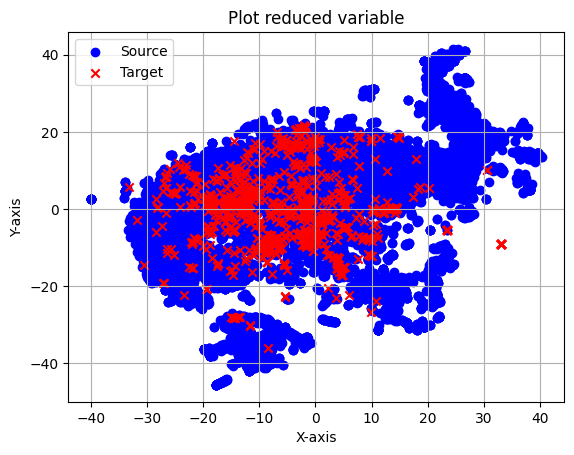

In [4]:
imgs_reduced_part1 = imgs_reduced[:13220]
imgs_reduced_part2 = imgs_reduced[13220:14111]

plt.scatter(imgs_reduced_part1[:,0], imgs_reduced_part1[:,1], label='Source', c='blue', marker='o')
plt.scatter(imgs_reduced_part2[:,0], imgs_reduced_part2[:,1], label='Target', c='red', marker='x')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Plot reduced variable')
plt.grid(True)
plt.show()

In [ ]:
# # 64,64にresizeした画像を表示
# image = cv2.imread(source_files[100])

# # 画像のリサイズ
# resized_image = cv2.resize(image, (64, 64))

# # 画像の表示
# plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
# plt.title('Source Image')
# plt.show()

In [5]:
import numpy as np

indices_1 = np.random.randint(0, 13220, 500)
indices_2 = np.random.randint(13220, 14111, 500)

# 両方のサンプリング結果を結合してindicesに格納
indices = np.concatenate([indices_1, indices_2])
indices = np.sort(indices)

In [6]:
selected_img_path = []
for i in indices.tolist():
    selected_img_path.append(img_file_path[i])
print(len(selected_img_path))

1000


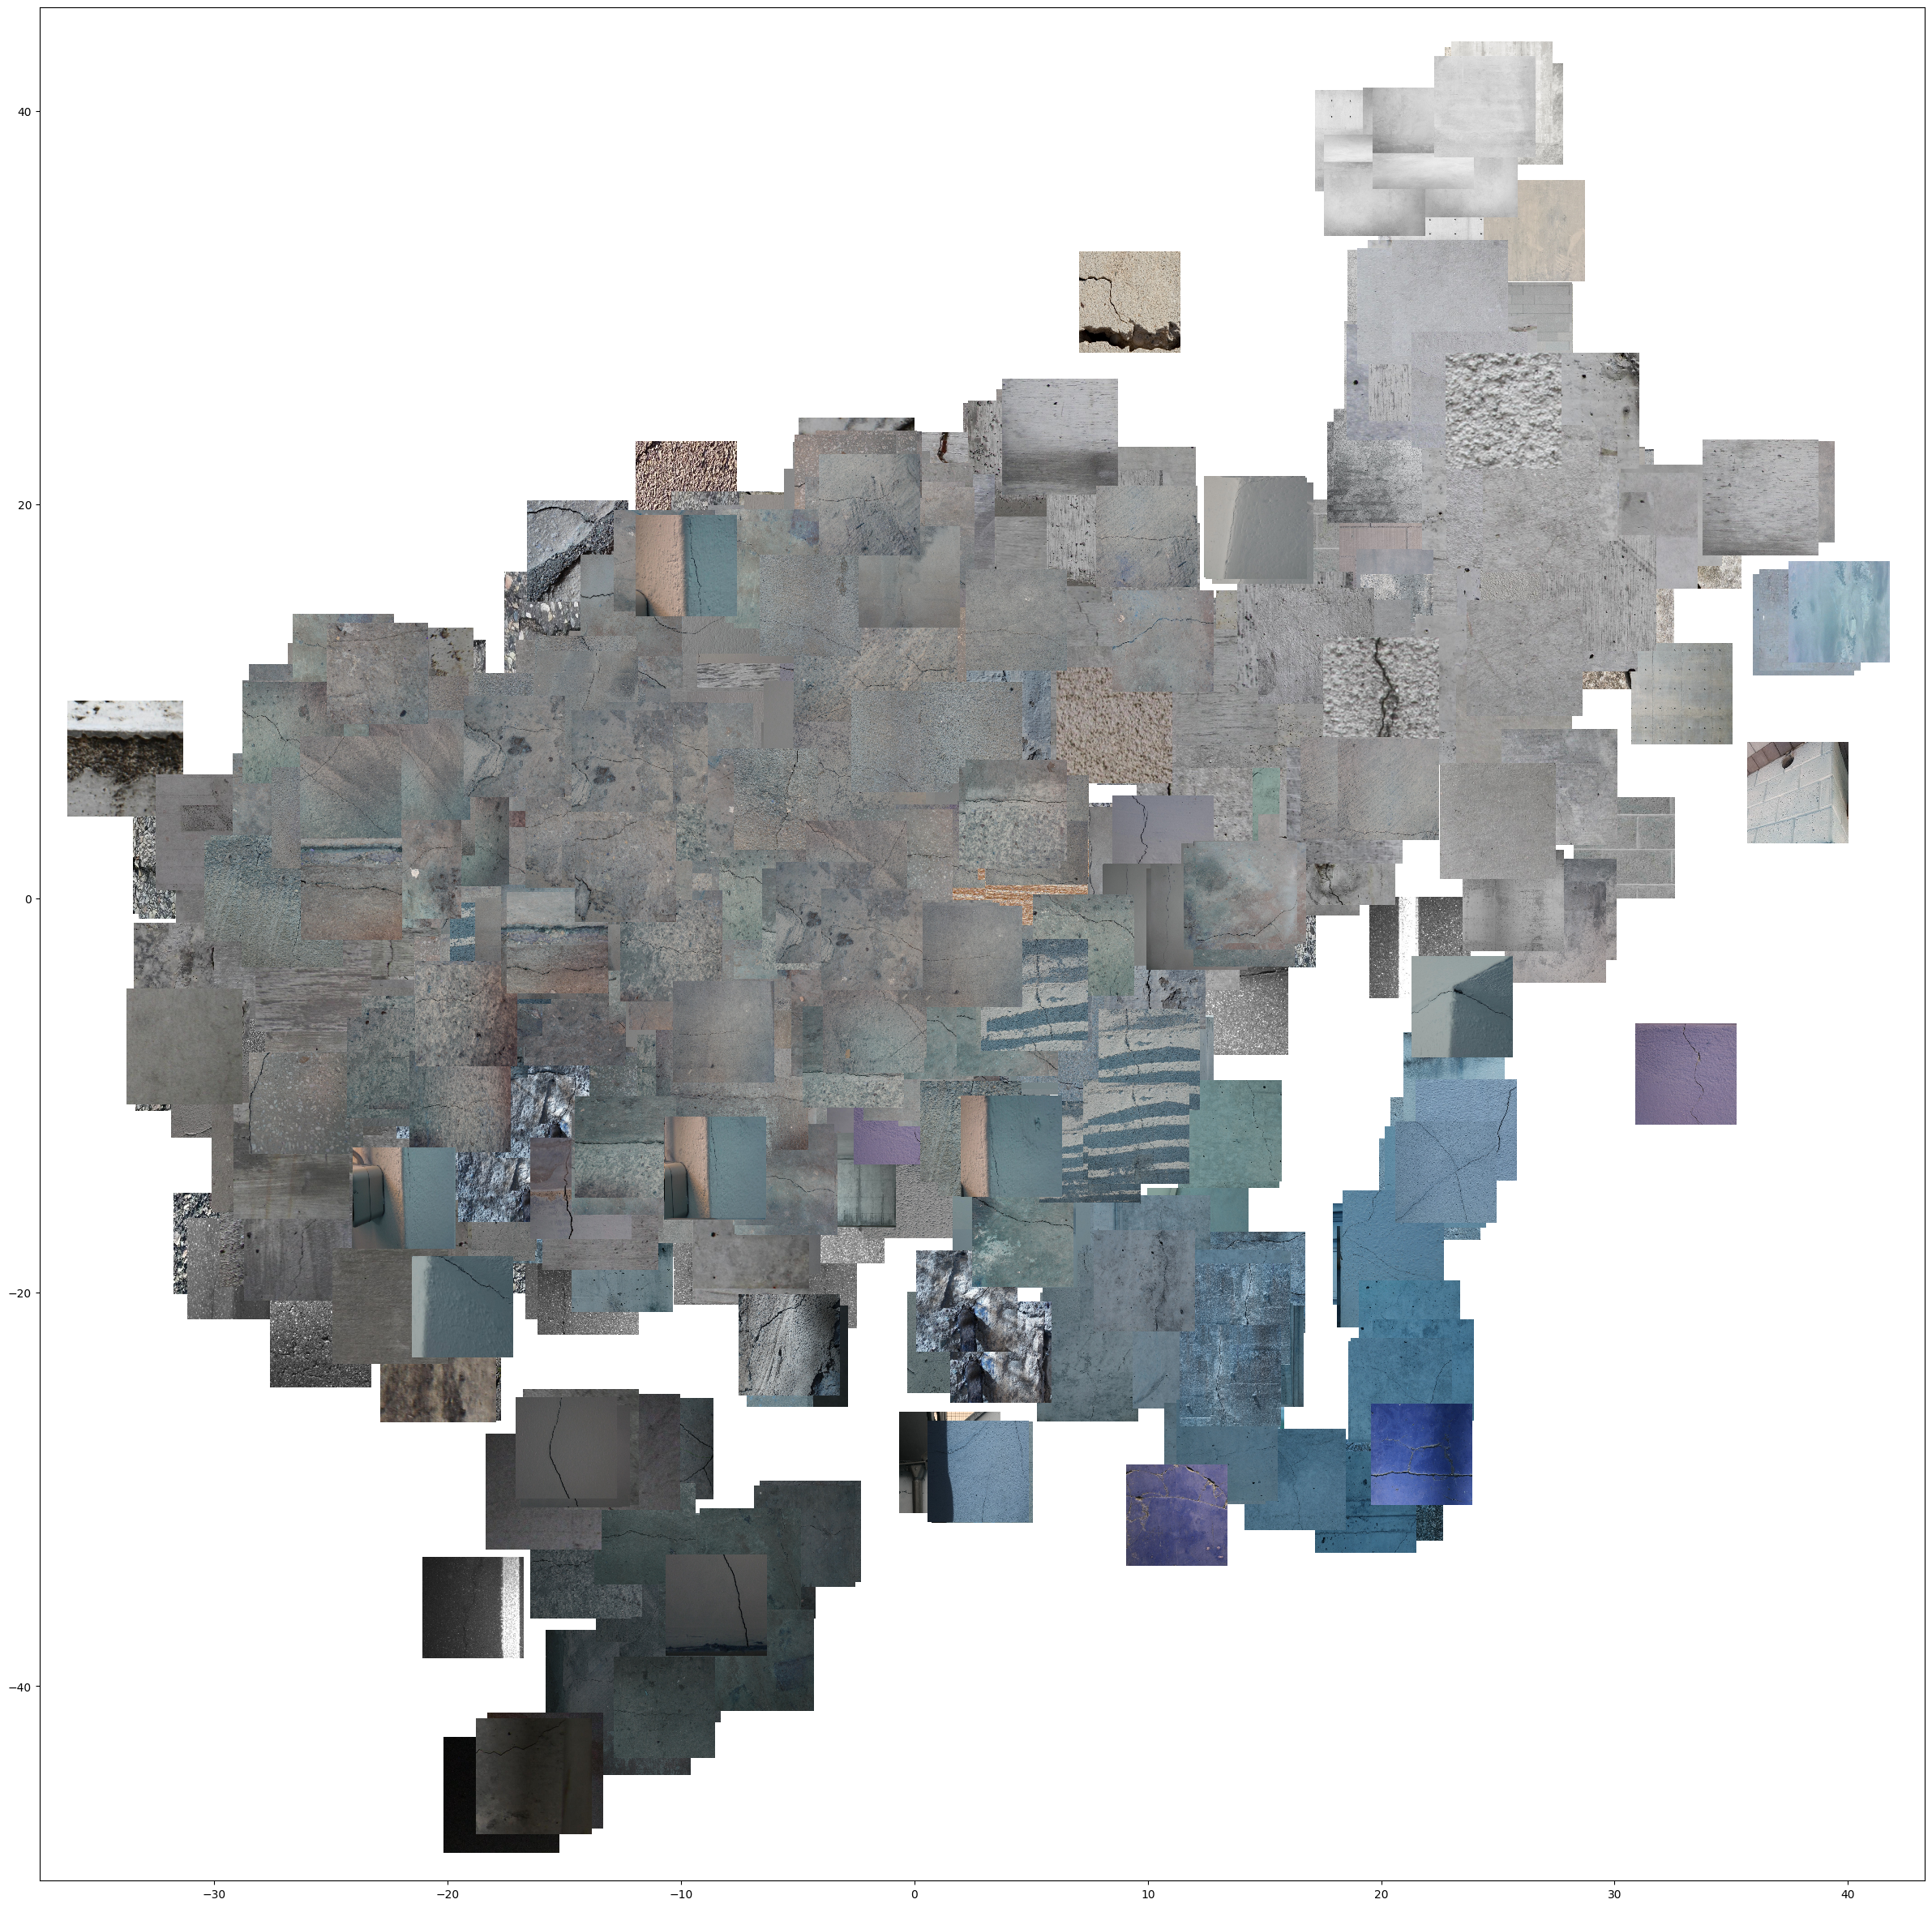

In [7]:
# source, targetからランダムに200個サンプリングし、画像プロット
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def imscatter(x, y, image_list, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    im_list = [OffsetImage(plt.imread(str(p)), zoom=zoom) for p in image_list]
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, im in zip(x, y, im_list):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# perplexity: 20
fig, ax = plt.subplots(figsize=(30,30))
imscatter(imgs_reduced[indices,0], imgs_reduced[indices,1], selected_img_path, ax=ax, zoom=0.2)

plt.show()

In [8]:
# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

X = np.load('imgs_reduced2.npy')
X_target = X[13220:]
X_source = X[:13220]

gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(X_target)

/home/ubuntu/domain-adaptation-for-crack-segmentation/env/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ubuntu/domain-adaptation-for-crack-segmentation/env/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


GaussianMixture(n_components=10, random_state=42)

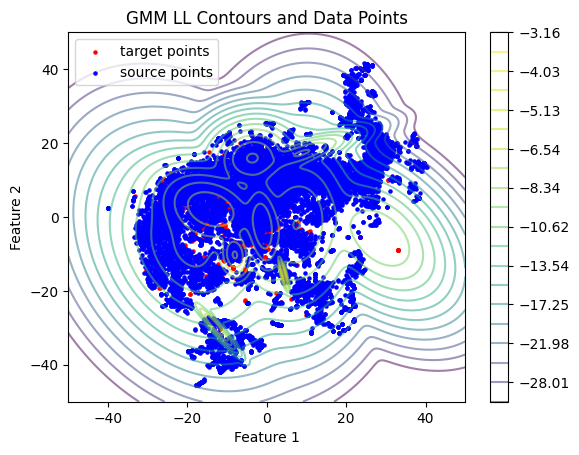

In [10]:
# メッシュグリッドの作成
x = np.linspace(-50, 50, 1000)
y = np.linspace(-50, 50, 1000)
X_mesh, Y_mesh = np.meshgrid(x, y)
XY_mesh = np.column_stack([X_mesh.ravel(), Y_mesh.ravel()])

# GMMの確率密度関数の計算
Z = gmm.score_samples(XY_mesh)
Z = Z.reshape(X_mesh.shape)

# データと等高線のプロット
plt.scatter(X_target[:, 0], X_target[:, 1], s=5, color='red', label='target points')
plt.scatter(X_source[:, 0], X_source[:, 1], s=5, color='blue', label='source points')
plt.contour(X_mesh, Y_mesh, Z, levels=np.sort(-np.logspace(0.5, 1.5, 20)), cmap='viridis', alpha=0.5)
plt.colorbar()

plt.title('GMM LL Contours and Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [11]:
Z_source = gmm.score_samples(X_source)
print(Z_source.shape)

(13220,)


In [12]:
source_prob = np.exp(Z_source)
source_prob

array([7.49785134e-04, 3.34211476e-04, 1.13491740e-03, ...,
       1.52942839e-07, 7.34894835e-06, 7.13956287e-06])

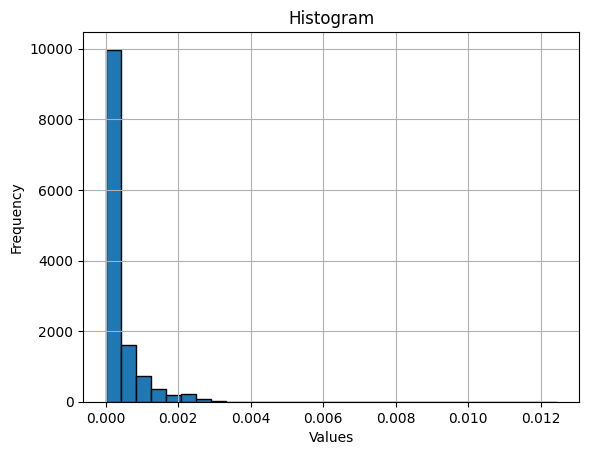

In [13]:
plt.hist(source_prob, bins=30, edgecolor='black')  # ヒストグラムのビン数を30に設定
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [14]:
np.save('source_weights2.npy', source_prob)

In [127]:
asdf = np.load('source_weights.npy')